In [1]:
!pip install shap
!pip install catboost

     |████████████████████████████████| 564 kB 5.4 MB/s 
     |████████████████████████████████| 76.6 MB 35 kB/s 


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
import shap


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = None

In [25]:
raw_data = pd.read_csv('/content/KPI Project Data 0120_1221.csv')
labeled_ml_data = pd.read_csv('labeled_ml.csv')

Columns (10,12,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284

In [26]:
# Focus only on Social channel
social_data = raw_data[raw_data.channel == 'Social'].drop(columns=['channel', 'size'])
social_data = social_data.iloc[:,:16]  # Data elements

to_drop = ['funnel', 'publisher', 'lob', 'product',	'theme', 'kpi_audience', 'creative_versions',
'price', 'price_placement', 'discount', 'offer_placement', 'video_type', 'length']

# Merge away outliers and concatenate target features
ml_data = pd.merge(social_data, labeled_ml_data.drop(to_drop, axis=1), left_on='Creative ID', right_on='Creative ID')
ml_data.drop(['Creative ID', 'offer_group', 'asset_type'], axis=1, inplace=True)
ml_data

,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,video_type,length,discount_applied,Mean_Spend,total_spend,total_Impressions,Mean_CTR,Mean_CVRS,Mean_CVRBF,Mean_CVRSV,Peak_CTR,Peak_CVRS,Peak_CVRBF,Peak_CVRSV,Med_CTR,Med_CVRS,Med_CVRBF,Med_CVRSV,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40
0,MF,Publisher 1,LOB 1,Product 1,Theme 1,Audience 1,Creative 1,No Price,NaN,0.00,NaN,Stock,:15,0,318.77,4144.00,204729.00,0.54,0.00,0.00,0.00,1.71,0.00,0.00,0.00,1.71,0.00,0.00,0.00,0.98,1.58,0.00,0.00,0.13,0.43,0.48,0.43,0.41,0.90,1.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,MF,Publisher 3,LOB 1,Product 1,Theme 1,Audience 2,Creative 1,No Price,NaN,0.00,NaN,Stock,:15,0,2953.33,26580.00,959822.00,0.29,0.25,25.07,0.12,0.49,1.49,37.77,0.27,0.49,1.49,37.77,0.27,0.49,0.35,0.26,0.27,0.27,0.26,0.23,0.24,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,37.77,35.93,34.39,17.91,25.14,21.20,16.44,25.02,11.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [27]:
ml_data.iloc[:,:14].isnull().sum()

funnel                  0
publisher               0
lob                     0
product                 0
theme                   0
kpi_audience            0
creative_versions       0
price                   0
price_placement      1199
discount                0
offer_placement      1199
video_type             92
length                  0
discount_applied        0
dtype: int64

In [28]:
ml_data.loc[ml_data.price_placement.isnull(), 'price_placement'] = 'Missing'
ml_data.loc[ml_data.offer_placement.isnull(), 'offer_placement'] = 'Missing'
ml_data.loc[ml_data.video_type.isnull(), 'video_type'] = 'Missing'

ml_data.iloc[:,:14].isnull().sum()

funnel               0
publisher            0
lob                  0
product              0
theme                0
kpi_audience         0
creative_versions    0
price                0
price_placement      0
discount             0
offer_placement      0
video_type           0
length               0
discount_applied     0
dtype: int64

In [29]:
X = ml_data.iloc[:,:14]
y = ml_data.iloc[:, 14:]

X['price_applied'] = X['price'].apply(lambda x: 1 if x != 'No Price' else 0)

In [30]:
X.head()

,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,video_type,length,discount_applied,price_applied
0,MF,Publisher 1,LOB 1,Product 1,Theme 1,Audience 1,Creative 1,No Price,Missing,0.00,Missing,Stock,:15,0,0
1,MF,Publisher 3,LOB 1,Product 1,Theme 1,Audience 2,Creative 1,No Price,Missing,0.00,Missing,Stock,:15,0,0
2,MF,Publisher 4,LOB 1,Product 1,Theme 1,Audience 2,Creative 1,No Price,Missing,0.00,Missing,Stock,:15,0,0
3,MF,Publisher 5,LOB 1,Product 1,Theme 1,Audience 2,Creative 1,No Price,Missing,0.00,Missing,Stock,:15,0,0
4,LF,Publisher 5,LOB 1,Product 2,Theme 1,Audience 2,Creative 2,Price 1,Missing,0.00,Missing,Stock,:15,0,1


In [31]:
y.head()

,Mean_Spend,total_spend,total_Impressions,Mean_CTR,Mean_CVRS,Mean_CVRBF,Mean_CVRSV,Peak_CTR,Peak_CVRS,Peak_CVRBF,Peak_CVRSV,Med_CTR,Med_CVRS,Med_CVRBF,Med_CVRSV,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40
0,318.77,4144.00,204729.00,0.54,0.00,0.00,0.00,1.71,0.00,0.00,0.00,1.71,0.00,0.00,0.00,0.98,1.58,0.00,0.00,0.13,0.43,0.48,0.43,0.41,0.90,1.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2953.33,26580.00,959822.00,0.29,0.25,25.07,0.12,0.49,1.49,37.77,0.27,0.49,1.49,37.77,0.27,0.49,0.35,0.26,0.27,0.27,0.26,0.23,0.24,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,37.77,35.93,34.39,17.91,25.14,21.20,16.44,25.02,11.82,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.15,0.11,0.12,0.11,0.09,0.08,0.10,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.49,0.17,0.17,0.16,0.15,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [33]:
cat_cols = ['funnel', 'publisher', 'lob', 'product', 'theme', 'kpi_audience', 'creative_versions',
'price', 'price_placement', 'offer_placement', 'video_type', 'length']

Learning rate set to 0.5
0:	learn: 0.3190382	total: 54.2ms	remaining: 2.66s
1:	learn: 0.2503111	total: 58.1ms	remaining: 1.4s
2:	learn: 0.2204731	total: 61.7ms	remaining: 967ms
3:	learn: 0.2070287	total: 65.5ms	remaining: 754ms
4:	learn: 0.2020328	total: 69ms	remaining: 621ms
5:	learn: 0.1969624	total: 72.2ms	remaining: 529ms
6:	learn: 0.1953251	total: 75.1ms	remaining: 461ms
7:	learn: 0.1877740	total: 77.9ms	remaining: 409ms
8:	learn: 0.1843687	total: 80.9ms	remaining: 368ms
9:	learn: 0.1784826	total: 83.7ms	remaining: 335ms
10:	learn: 0.1782127	total: 91.2ms	remaining: 323ms
11:	learn: 0.1753583	total: 94.8ms	remaining: 300ms
12:	learn: 0.1726686	total: 97.8ms	remaining: 278ms
13:	learn: 0.1698172	total: 102ms	remaining: 261ms
14:	learn: 0.1664357	total: 105ms	remaining: 244ms
15:	learn: 0.1603482	total: 108ms	remaining: 230ms
16:	learn: 0.1603433	total: 110ms	remaining: 214ms
17:	learn: 0.1592510	total: 113ms	remaining: 201ms
18:	learn: 0.1587581	total: 116ms	remaining: 189ms
19:	le

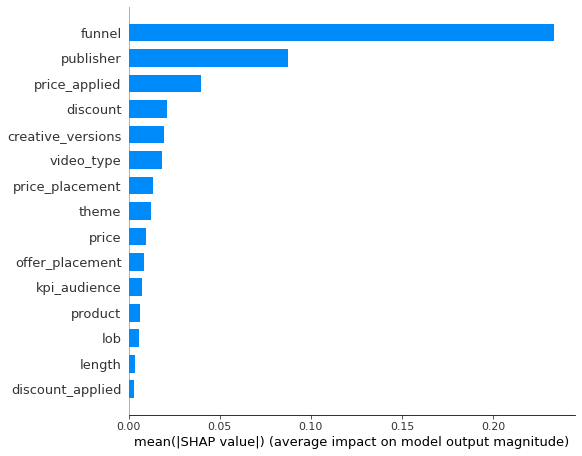

In [34]:
cbr = CatBoostRegressor(iterations=50, random_state=123)
cbr.fit(X, y['Mean_CTR'], cat_features=cat_cols)

shap_values = shap.TreeExplainer(cbr).shap_values(X)

# Visualize the first prediction's explanation
shap.summary_plot(shap_values, X, plot_type="bar")

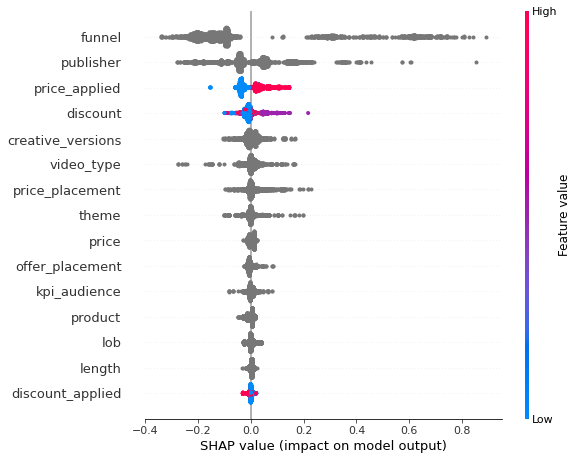

In [35]:
# Summarize the effects of all the features
shap.summary_plot(shap_values, X)

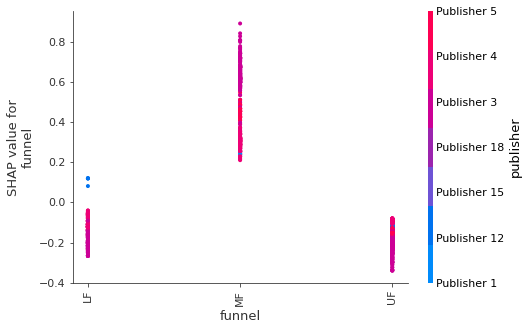

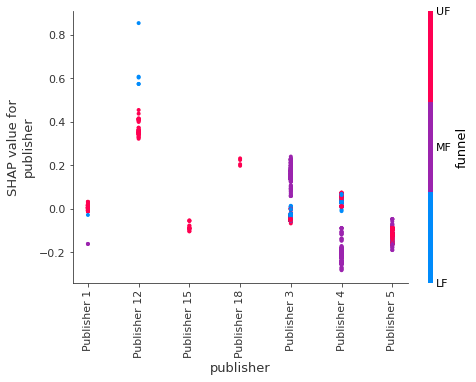

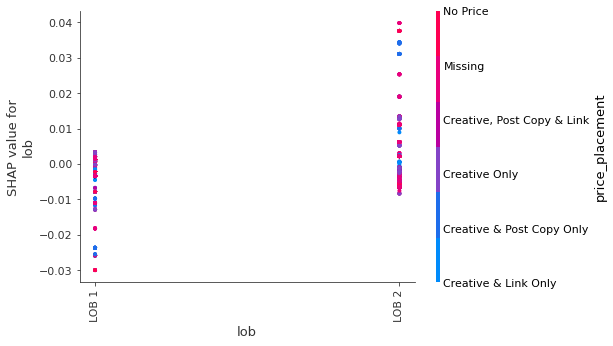

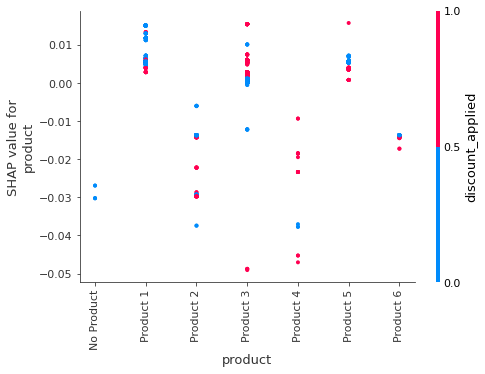

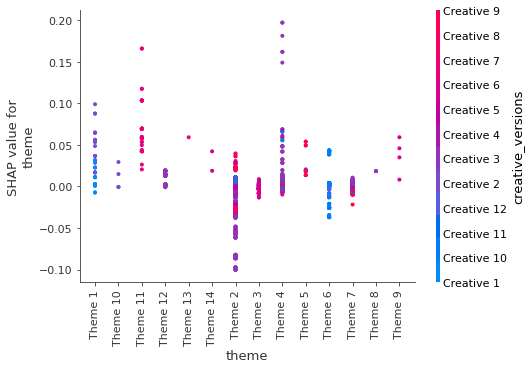

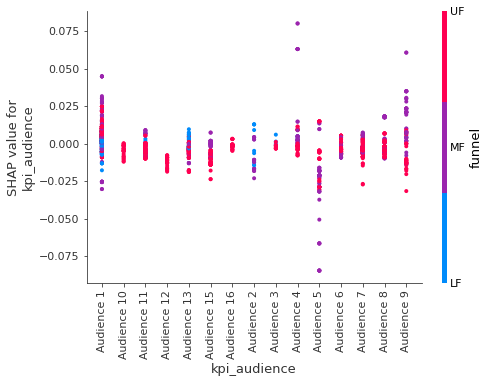

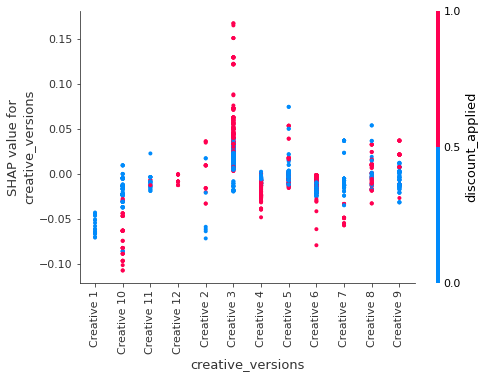

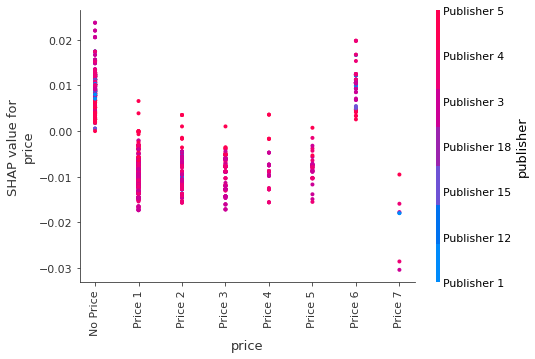

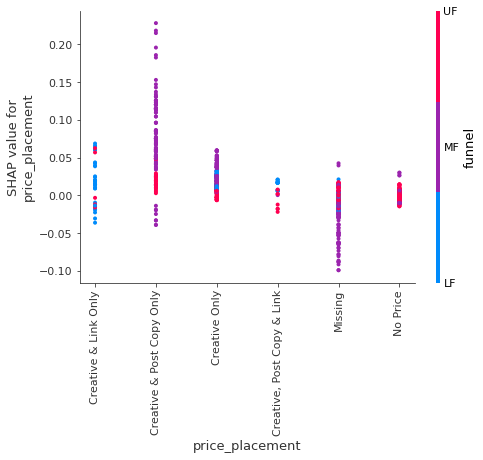

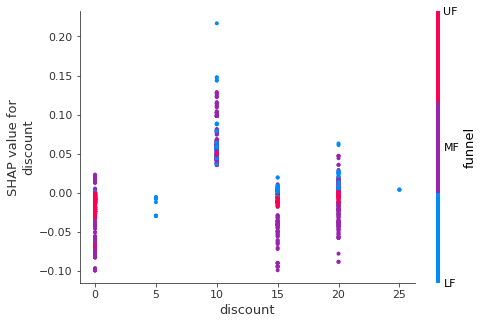

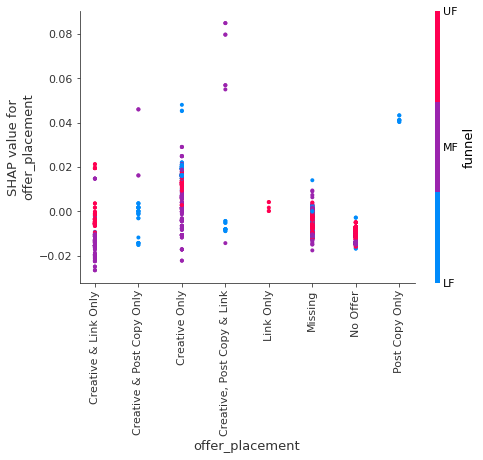

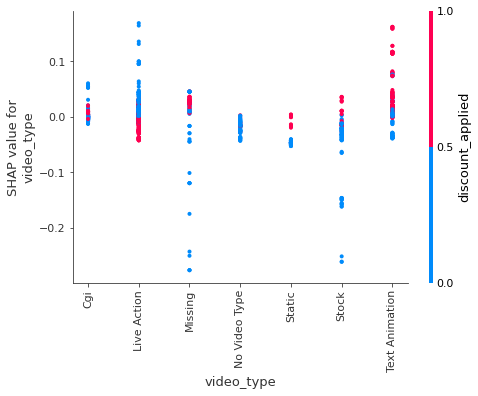

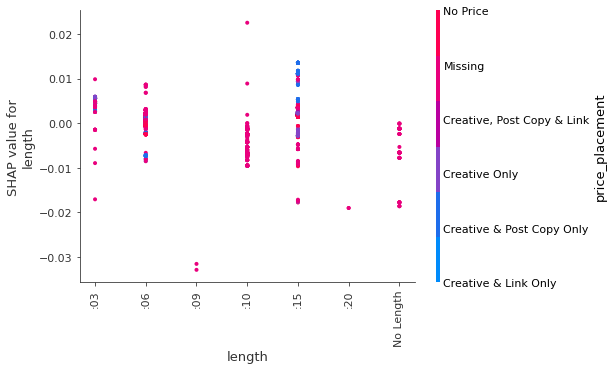

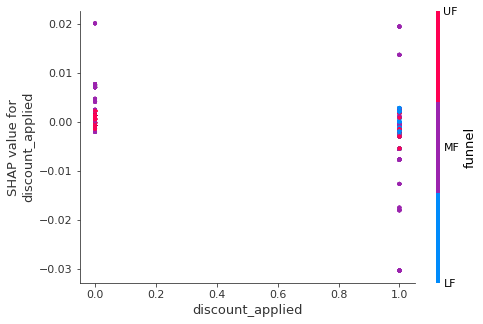

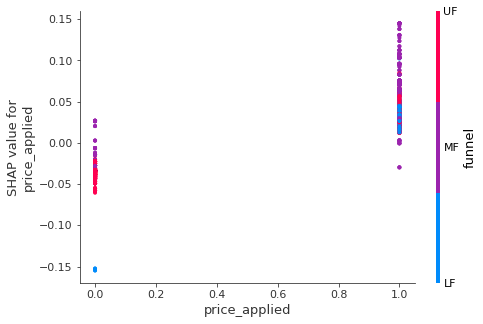

In [ ]:
for feature in X.columns:
  shap.dependence_plot(feature, shap_values, X)